In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import sklearn
import sys
import pandas as pd
import pickle
from AMLpp.transformers import *
from AMLpp.conveyor import *
from AMLpp.architect import *
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

import warnings
warnings.filterwarnings("ignore")

# ПОДГОТОВКА ДАННЫХ

In [45]:
import pandas as pd

train = pd.read_excel('tr_6-9k_newubki_s56_not[0]_y21_m1-5_new.xlsx')
test = pd.read_excel('tt_2-6k_newubki_y21_m6_new.xlsx')

In [57]:
import pickle 
from user_transformer import UserTransform_status56
with open('model', 'rb') as file:
    model = pickle.load(file)
model

Conveyor= (
           Word2Vectorization(columns=['purpose_other'], level_formatting=1, epochs=5000, min_count=1, window=5, vector_size=20), 
           CategoricalEncoder(columns=['organization_type_other', 'position_other', 'email', 'purpose_other', 'ceduc', 'family', 'sstate', 'cgrag', 'income_source_id', 'income_frequency_id', 'has_prior_employment', 'empoyees_count_id', 'organization_branch_id', 'organization_type_id', 'position_id', 'employment_type_id', 'has_movables', 'has_immovables', 'fact_addr_owner_type_id', 'fact_addr_region_id', 'fact_addr_same', 'addr_region_id', 'education_id', 'children_count_id', 'marital_status_id', 'gender_id', 'addr_owner_type_id', 'country_det', 'city_det', 'region_det', 'isp', 'browser', 'system', 'brand']), 
           ImputerIterative(columns=None, max_iter=10, initial_strategy=mean, missing_values=nan), 
           PolynomialFeatures(), 
           LGBMRegressor(cat_smooth=35, colsample_bytree=0.5, learning_rate=0.005,
              min_child

In [58]:
train_x = train.copy()
del train_x['status_id']
del train_x['overdue_days']

train_y = train[['overdue_days', 'status_id']]

test_x = test.copy()
del test_x['status_id']
del test_x['overdue_days']

test_y = test[['overdue_days', 'status_id']]

In [59]:
X_train, Y_train = model.transform(train_x, train_y)
X_test, Y_test = model.transform(test_x, test_y)
categorical_columns = ['organization_type_other', 'position_other', 'email', 'ceduc', 'family', 'sstate', 'cgrag', 'income_source_id',
                      'income_frequency_id', 'has_prior_employment', 'empoyees_count_id', 'organization_branch_id', 'organization_type_id', 'position_id',
                      'employment_type_id', 'has_movables', 'has_immovables', 'fact_addr_owner_type_id', 'fact_addr_region_id', 'fact_addr_same', 'addr_owner_type_id',
                      'addr_region_id', 'education_id', 'children_count_id', 'marital_status_id', 'gender_id', 
                      'country_det','city_det', 'region_det', 'isp', 'browser', 'system', 'brand'
                      ]

In [60]:
all_columns = list(X_train.columns)
categorical_columns = [col for col in categorical_columns if col in all_columns]

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

# ОПТИМИЗАЦИЯ

In [65]:
from typing import List
from lightgbm import LGBMRegressor
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.model_selection import train_test_split

class Optimizer(object):
    def __init__(self, X_train:pd.DataFrame, Y_train:pd.DataFrame, 
                       X_test:pd.DataFrame, Y_test:pd.DataFrame,
                       all_columns:List[str] = None, categorical_columns:List[str]=None,
                       ):

        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test
        self.all_columns = all_columns
        self.categorical_columns = categorical_columns

    def __call__(self, trial):
        random_state = trial.suggest_int('test_split',0,100)
        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(X_train, Y_train, test_size=0.1, random_state = random_state)
        params = {
        'metric': 'rmse', 
        'random_state': trial.suggest_int('random_state',0,100),
        'n_estimators': 10000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.35,0.4,0.45,0.5,0.6,0.7,0.75,0.8,0.85]),
        'subsample': trial.suggest_categorical('subsample', [0.6,0.65,0.7,0.75,0.8,0.85]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.005,0.006,0.008,0.01,0.015,0.02,0.03]),
        'max_depth': trial.suggest_categorical('max_depth', [-1,10,20]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 300),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('cat_smooth', 1, 100)
        }
        model = LGBMRegressor(**params)
        # model.fit(self.X_train, self.Y_train, eval_set = [(self.X_test, self.Y_test)], verbose = False, 
        #     early_stopping_rounds=300, feature_name = self.all_columns, categorical_feature=self.categorical_columns)
        model.fit(self.X_train, self.Y_train, eval_set = [(self.X_test, self.Y_test)], verbose = False, 
            early_stopping_rounds=300)
        preds = model.predict(self.X_test)

        # return roc_auc_score(self.Y_test, preds)
        return r2_score(self.Y_test, preds)

In [66]:
study = optuna.create_study(direction='maximize')
study.optimize(Optimizer(X_train, Y_train, X_test, Y_test,
             all_columns = all_columns, categorical_columns = categorical_columns), n_trials=20,  n_jobs = -1)

[I 2021-07-14 14:25:16,385] A new study created in memory with name: no-name-b409518d-868a-405d-911c-cfe890f296d8
[I 2021-07-14 14:27:22,190] Trial 3 finished with value: 0.09886688287275724 and parameters: {'test_split': 63, 'random_state': 17, 'reg_alpha': 0.01650378272809231, 'reg_lambda': 8.039766956741412, 'colsample_bytree': 0.35, 'subsample': 0.85, 'learning_rate': 0.008, 'max_depth': -1, 'num_leaves': 8, 'min_child_samples': 280, 'cat_smooth': 61}. Best is trial 3 with value: 0.09886688287275724.
[I 2021-07-14 14:29:22,843] Trial 1 finished with value: 0.3769409837612787 and parameters: {'test_split': 66, 'random_state': 43, 'reg_alpha': 0.03422715119023706, 'reg_lambda': 0.009056063246722246, 'colsample_bytree': 0.85, 'subsample': 0.6, 'learning_rate': 0.005, 'max_depth': 10, 'num_leaves': 218, 'min_child_samples': 98, 'cat_smooth': 58}. Best is trial 1 with value: 0.3769409837612787.
[I 2021-07-14 14:30:16,823] Trial 4 finished with value: 0.409568634926869 and parameters: {'

In [10]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor

booster = LGBMRegressor(**study.best_params)

booster.fit(X_train, Y_train, eval_metric="rmse", feature_name = list(X_train.columns), categorical_feature=categorical_columns)

[LightGBM] [Warning] Unknown parameter: min_data_per_groups


LGBMRegressor(colsample_bytree=0.7, learning_rate=0.02, min_child_samples=228,
              min_data_per_groups=52, num_leaves=211,
              reg_alpha=0.0013439135738175028, reg_lambda=0.1709251939412349,
              subsample=0.65)

In [11]:
from sklearn.metrics import r2_score, roc_auc_score

test_preds = booster.predict(X_test)
train_preds = booster.predict(X_train)

print("Test  roc_auc_score Score : %.2f"%roc_auc_score(Y_test, test_preds))
print("Train roc_auc_score Score : %.2f"%roc_auc_score(Y_train, train_preds))
print("Test  R2 Score : %.2f"%r2_score(Y_test, test_preds))
print("Train R2 Score : %.2f"%r2_score(Y_train, train_preds))

Test  roc_auc_score Score : 0.79
Train roc_auc_score Score : 0.79
Test  R2 Score : -0.38
Train R2 Score : 0.17


New EV score: 0.11120495609180014


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

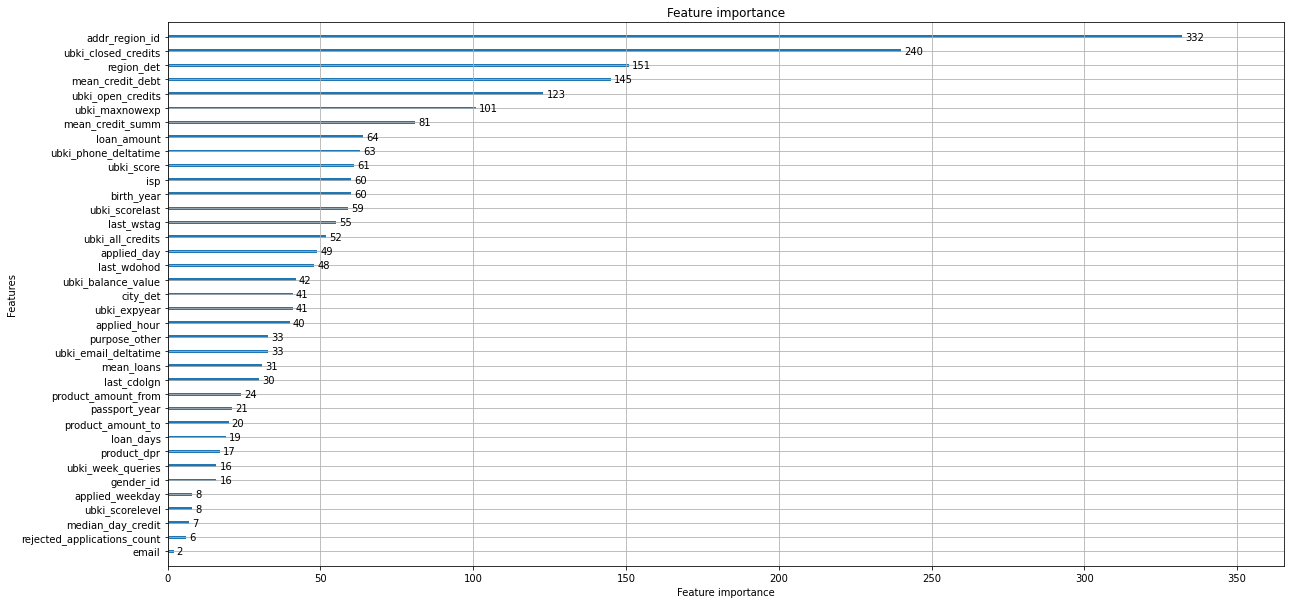

In [12]:
from sklearn.metrics import explained_variance_score
new_predict = booster.predict(X_test)
print('New EV score:', explained_variance_score(Y_test, new_predict))
lgb.plot_importance(booster, figsize=(20, 10))